# 선형회귀(Linear Regression)
- 머신러닝 알고리즘들은 선형회귀를 중심으로 해서 응용된 형태
- 딥러닝은 그냥 선형회귀이다.
    - 딥러닝을 딥러닝이라고 하지 않고 그냥 선형회귀라고 부르는 사람들도 있다.

## Remind
- 입력변수 x에 대한 반응변수 y의 관계
    - x에 따른 y가 비례관계에 있을것이다는 것을 가정
    - x는 수집된/관찰된 자료(분포를 가정) - 정규분포
    - 오차항도 정규분포를 가정
- y의 형태에 따라서 모형이 달라진다.
    - y가 이산적, 범주형, ... 이라면 분류 모델로 만들어 볼 수 있었다.
    - y사 연수형, 실수형, ... 이라면 예측 모델로 만들어 볼 수 있었다.
    - 이 두가지는 지도 학습의 대표적인 방법이다.

## overfit(과적합)
- 회귀계수를 축소
    - Ridge and Rasso
- 변수 선택법(AIC)
    - 전진선택법
    - 후진제거법
    - 단계적 선택법
- 다중 공선성 제거
    - VIF를 이용한 변수 선택
> 어떠한 방법도 과적합을 항상 없앨 수는 없다.
> 과적합은 모형을 만드는데 있어서 항상 따라다니는 문제

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 통계적 모형(선형회귀)
import statsmodels.api as sm

# 머신러닝 관련
# pip install scikit-learn
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error

In [3]:
rawData = pd.read_csv('./london_merged.csv')

In [4]:
rawData.weather_code.unique()

array([ 3.,  1.,  4.,  7.,  2., 26., 10.])

In [8]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [9]:
rawData['cnt'].shift(1)

0           NaN
1         182.0
2         138.0
3         134.0
4          72.0
          ...  
17409    2220.0
17410    1042.0
17411     541.0
17412     337.0
17413     224.0
Name: cnt, Length: 17414, dtype: float64

# 전처리
- 수집된 자료를 붙이고, 자르고, 지우고, 추가하고..
    - 예) 날씨데이터, 휴일데이터, 자전거 대여

- 수집된 자료를 가공하는 작업

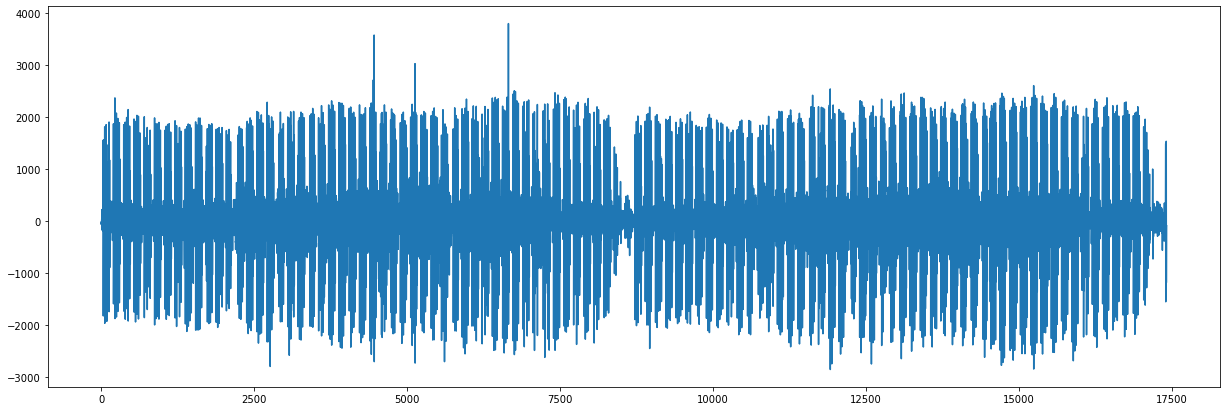

In [15]:
rawData['cnt'].diff().plot(kind='line', figsize=(21, 7))
plt.show()

In [16]:
rawData['diff'] = rawData['cnt'].diff()

In [17]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,diff
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,NaN
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,-44.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,-4.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,-62.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,-1178.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,-501.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,-204.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,-113.0


In [19]:
rawData['diff'].fillna(method='bfill', inplace=True)

In [20]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,diff
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,-44.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,-44.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,-4.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,-62.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,-1178.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,-501.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,-204.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,-113.0


## Y에 대한 영향이 얼마나 될지 시각적으로 확인
- 지난번 데이터는 워싱턴DC에서 발생한 데이터 여쏙
- 런던 바이크 쉐어링 데이터는 어떤 패턴일 지 확인해보기.
- 추가적으로 leg count, diff 등의 패턴이 추가되었으므로, 추출된 패턴이 얼마나 영향을 주는지 확인..

findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.


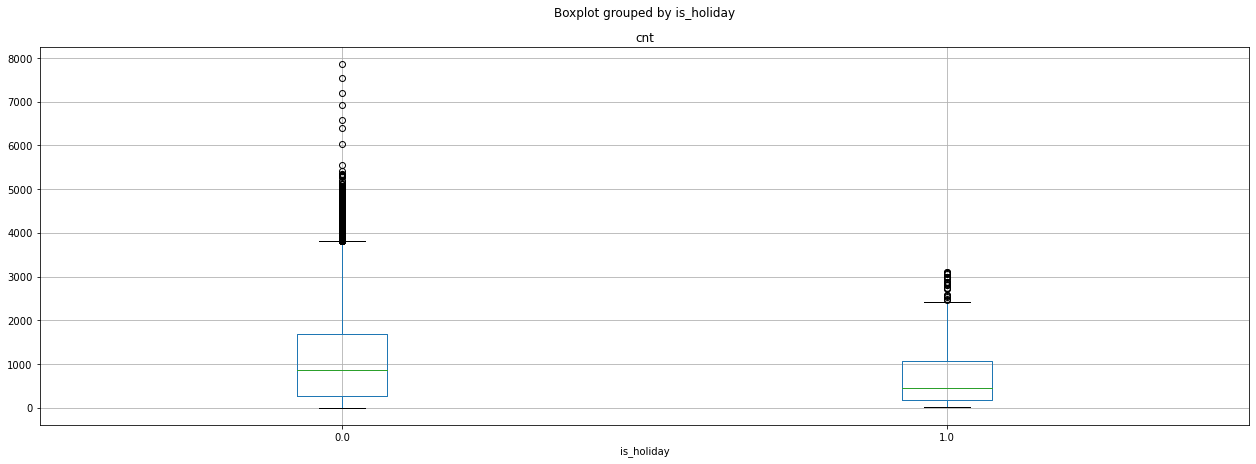

In [22]:
# box-plot, scatter plot, histogram, ...
rawData.boxplot(column='cnt', by='is_holiday', grid=True, figsize=(21,7))
plt.show()

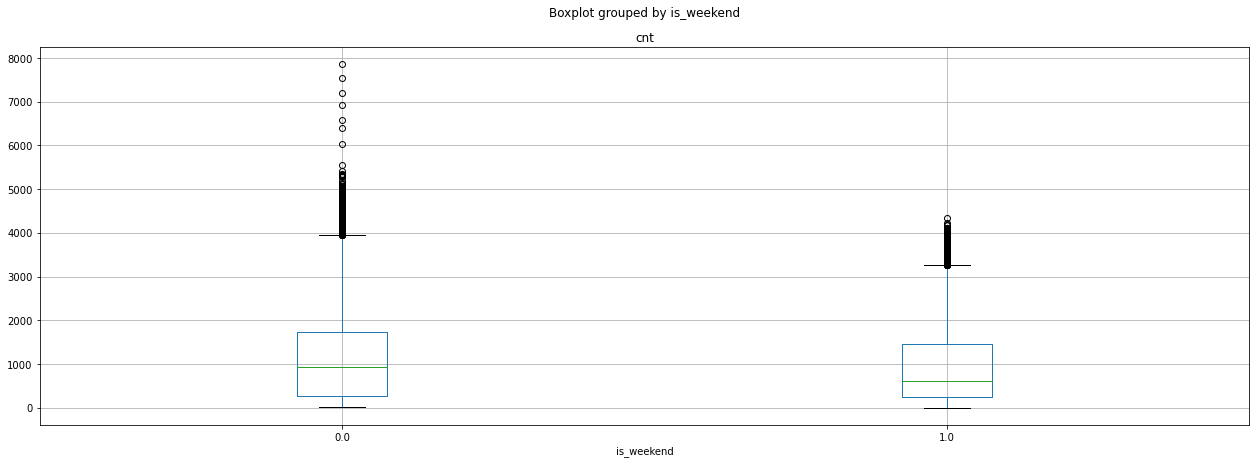

In [23]:
# box-plot, scatter plot, histogram, ...
rawData.boxplot(column='cnt', by='is_weekend', grid=True, figsize=(21,7))
plt.show()

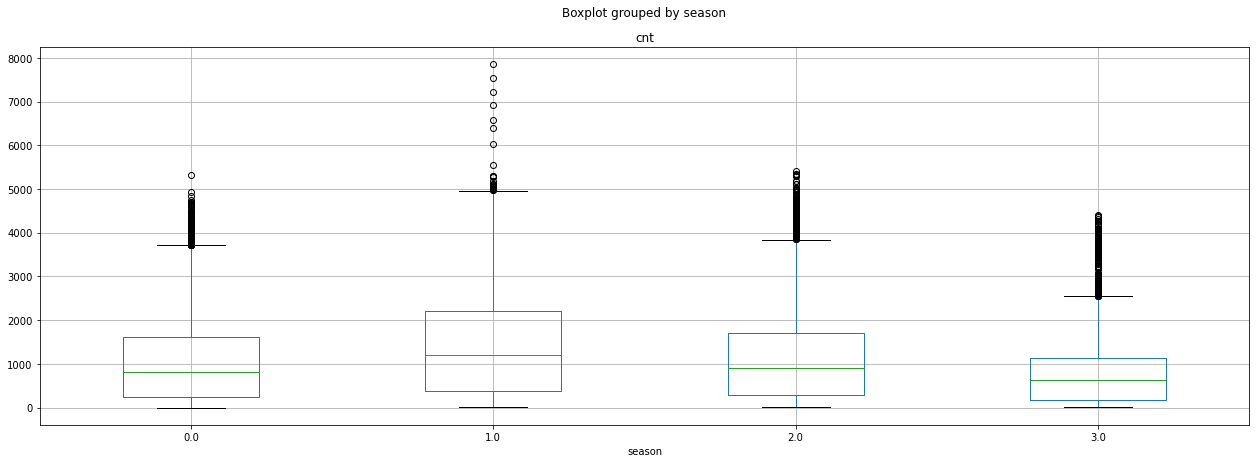

In [24]:
# box-plot, scatter plot, histogram, ...
rawData.boxplot(column='cnt', by='season', grid=True, figsize=(21,7))
plt.show()

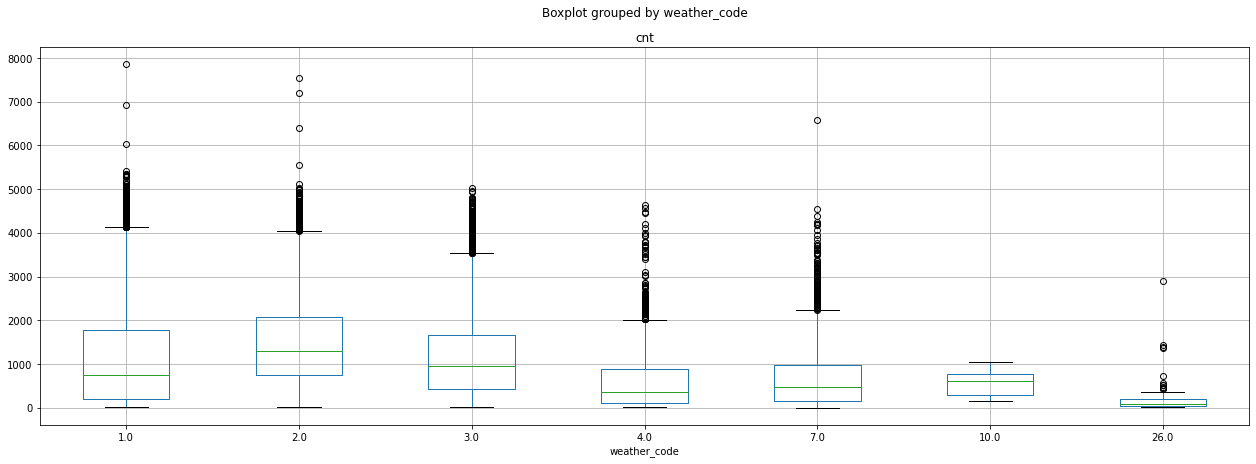

In [25]:
# box-plot, scatter plot, histogram, ...
rawData.boxplot(column='cnt', by='weather_code', grid=True, figsize=(21,7))
plt.show()

In [28]:
rawData['timestamp'] = pd.to_datetime(rawData['timestamp'])

In [47]:
rawData['datetime'] = rawData['timestamp']

In [51]:
rawData.set_index('datetime', inplace=True)

In [29]:
rawData['hour'] = rawData.timestamp.dt.hour

In [31]:
rawData['month'] = rawData.timestamp.dt.month

In [46]:
rawData['dayofweek'] = rawData.timestamp.dt.dayofweek

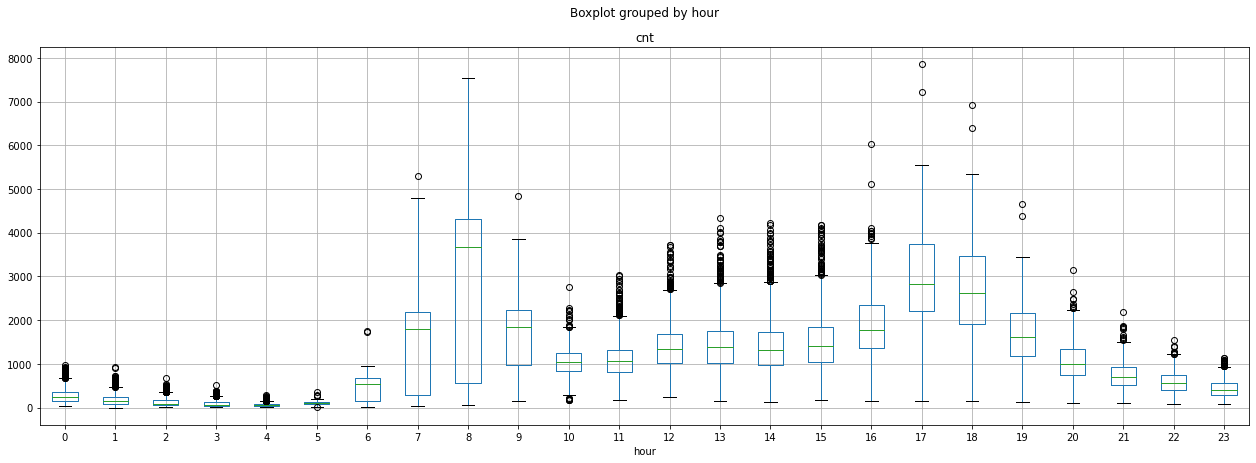

In [30]:
rawData.boxplot(column='cnt', by='hour', grid=True, figsize=(21,7))
plt.show()

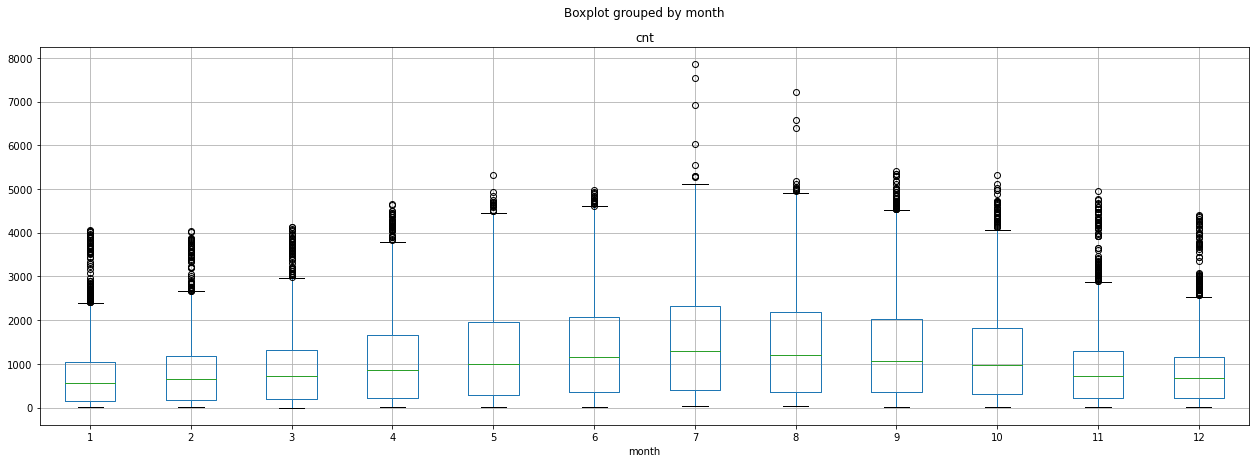

In [32]:
rawData.boxplot(column='cnt', by='month', grid=True, figsize=(21,7))
plt.show()

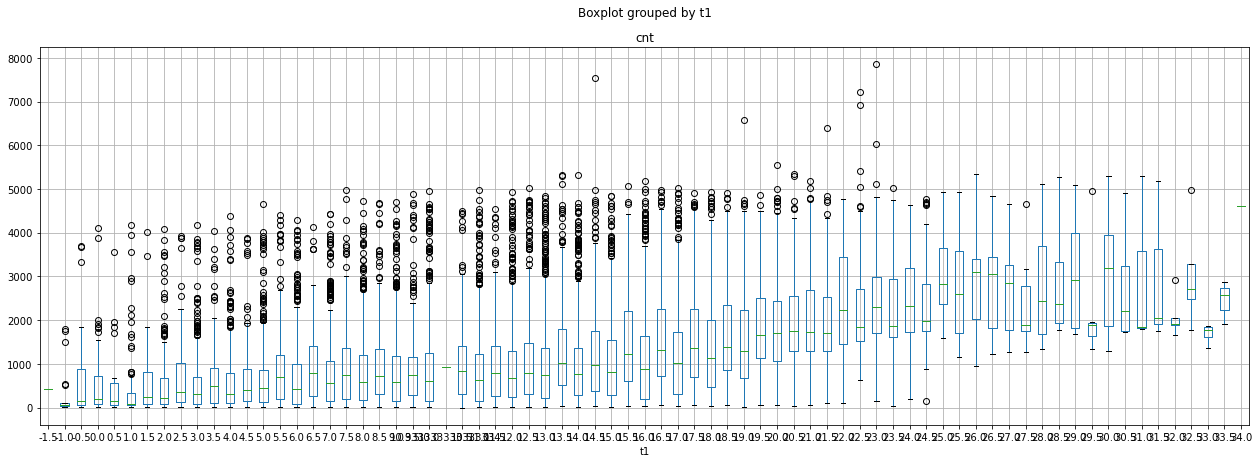

In [33]:
rawData.boxplot(column='cnt', by='t1', grid=True, figsize=(21, 7))
plt.show()

In [34]:
rawData.columns

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season', 'diff', 'hour', 'month'],
      dtype='object')

In [35]:
rawData['lag_cnt1'] = rawData['cnt'].shift(1) # lag_cnt1을 `1칸`씩 아래로 밀어준다.
rawData['lag_cnt2'] = rawData['cnt'].shift(2) # lag_cnt2을 `2칸`씩 아래로 밀어준다.

In [36]:
rawData['lag_cnt1'].fillna(method='bfill', inplace=True)

In [37]:
rawData['lag_cnt2'].fillna(method='bfill', inplace=True)

In [38]:
rawData.columns

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season', 'diff', 'hour', 'month',
       'lag_cnt1', 'lag_cnt2'],
      dtype='object')

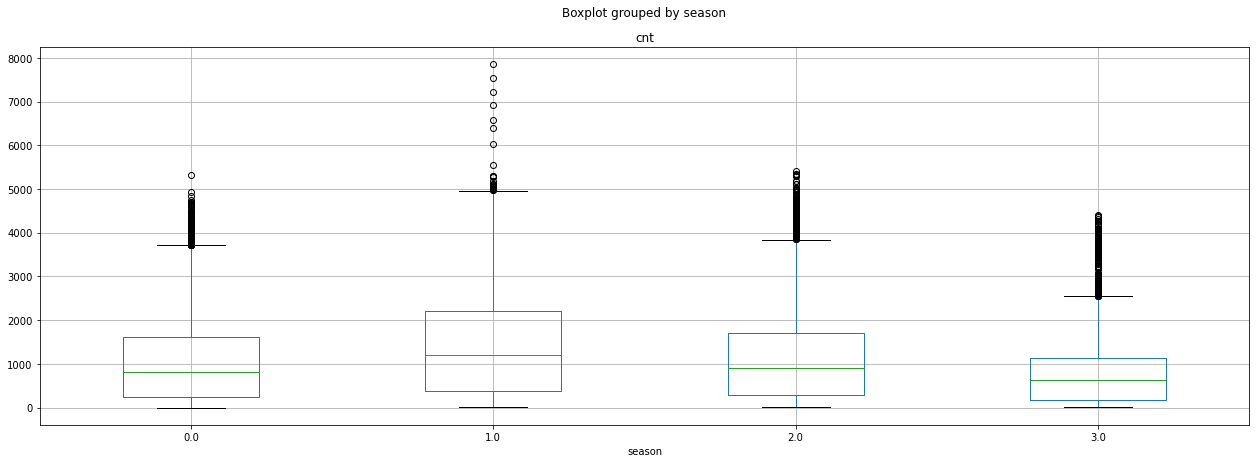

In [39]:
rawData.boxplot(column='cnt', by='season', grid=True, figsize=(21, 7))
plt.show()

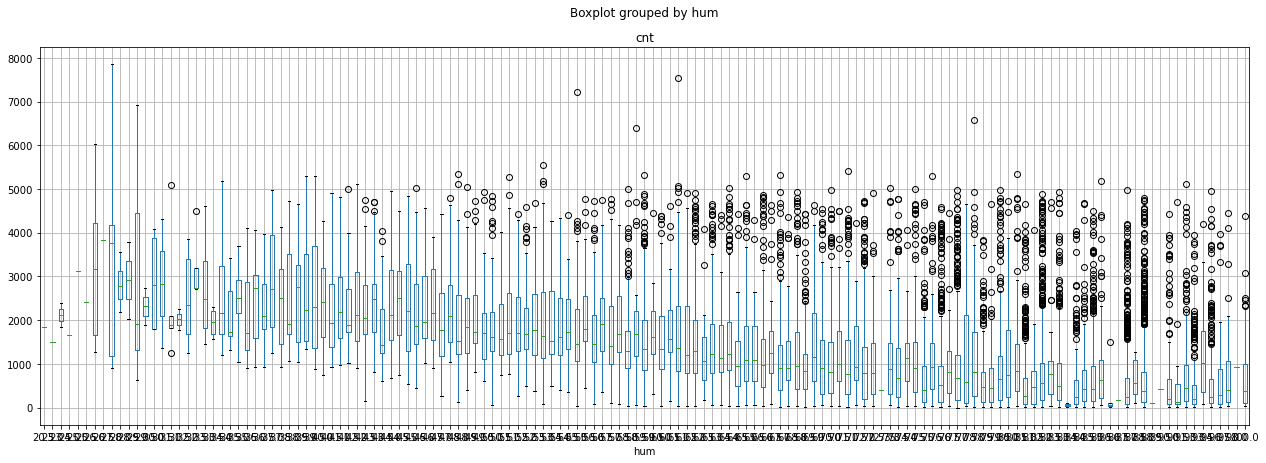

In [41]:
rawData.boxplot(column='cnt', by='hum', grid=True, figsize=(21, 7))
plt.show()

## 학습/테스트 셋 분리

### London bike sharing
- `2015.01.04` ~ `2017.01.03`
- 학습/테스트 셋
    - 과거의 데이터를 학습 셋으로 하고, 미래의 데이터를 테스트 셋으로 해서 검증
    - `2015.01.04` ~ `2016.07.31` 까지를 학습 데이터
    - 그 이후에 데이터를 검증 셋으로 해서 분류

In [65]:
rawData['timestamp'].dropna(inplace=True, axis=0)

In [66]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
 10  diff          17414 non-null  float64       
 11  hour          17414 non-null  int64         
 12  month         17414 non-null  int64         
 13  lag_cnt1      17414 non-null  float64       
 14  lag_cnt2      17414 non-null  float64       
 15  d

In [52]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,diff,hour,month,lag_cnt1,lag_cnt2,dayofweek
datetime,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,-44.0,0,1,182.0,182.0,6
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,-44.0,1,1,182.0,182.0,6
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,-4.0,2,1,138.0,182.0,6
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,-62.0,3,1,134.0,138.0,6
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,-25.0,4,1,72.0,134.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,-1178.0,19,1,2220.0,2742.0,1
2017-01-03 20:00:00,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,-501.0,20,1,1042.0,2220.0,1
2017-01-03 21:00:00,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,-204.0,21,1,541.0,1042.0,1


In [53]:
rawTrain = rawData.loc[rawData.index < '2016-08-01', :]
rawTest = rawData.loc[rawData.index >= '2016-08-01', :]
print(rawTrain.shape, rawTest.shape)

(13713, 16) (3701, 16)


In [55]:
x_train = rawTrain.loc[:,'t1':]
y_train = rawTrain['cnt']
x_test = rawTest.loc[:, 't1':]
y_test = rawTest['cnt']
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(13713, 14) (13713,)
(3701, 14) (3701,)


In [56]:
x_train

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,diff,hour,month,lag_cnt1,lag_cnt2,dayofweek
datetime,,,,,,,,,,,,,,
2015-01-04 00:00:00,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,-44.0,0,1,182.0,182.0,6
2015-01-04 01:00:00,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,-44.0,1,1,182.0,182.0,6
2015-01-04 02:00:00,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,-4.0,2,1,138.0,182.0,6
2015-01-04 03:00:00,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,-62.0,3,1,134.0,138.0,6
2015-01-04 04:00:00,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,-25.0,4,1,72.0,134.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-31 19:00:00,21.0,21.0,48.0,8.0,1.0,0.0,1.0,1.0,-584.0,19,7,3469.0,3856.0,6
2016-07-31 20:00:00,21.0,21.0,50.0,9.0,1.0,0.0,1.0,1.0,-762.0,20,7,2885.0,3469.0,6
2016-07-31 21:00:00,20.5,20.5,51.5,12.0,1.0,0.0,1.0,1.0,-777.0,21,7,2123.0,2885.0,6


In [57]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
 10  diff          17414 non-null  float64       
 11  hour          17414 non-null  int64         
 12  month         17414 non-null  int64         
 13  lag_cnt1      17414 non-null  float64       
 14  lag_cnt2      17414 non-null  float64       
 15  d

In [59]:
rawData.loc[rawData['timestamp'].isna()]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,diff,hour,month,lag_cnt1,lag_cnt2,dayofweek
datetime,,,,,,,,,,,,,,,,


In [61]:
rawData.dropna(inplace=True)

In [68]:
model1 = sm.OLS(y_train, x_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.672e+10
Date:                Mon, 04 Jan 2021   Prob (F-statistic):                        0.00
Time:                        12:43:50   Log-Likelihood:                         -6027.1
No. Observations:               13713   AIC:                                  1.208e+04
Df Residuals:                   13699   BIC:                                  1.219e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
t1              -0.0060      0.004     -1.580      0.114      -0.013       0.001
t2               0.0052      0.003      1.586      0.113      -0.001       0.012
hum              0.0003      0.000      2.026      0.043    1.08e-05       0.001
wind_speed   -8.071e-05      0.000     -0.181      0.856      -0.001       0.001
weather_code    -0.0005      0.001     -0.336      0.737      -0.003       0.002
is_holiday       0.0034      0.023      0.148      0.882      -0.041       0.048
is_weekend       0.0075      0.012      0.646      0.518      -0.015       0.030
season           0.0045      0.003      1.482      0.138      -0.001       0.010
diff             1.0000   5.55e-06    1.8e+05      0.000       1.000       1.000
hour            -0.0008      0.001     -1.404      0.160      -0.002       0.000
month           -0.0021      0.001     -1.657      0.097      -0.005       0.000
lag_cnt1         1.0000   4.94e-06   2.02e+05      0.000       1.000       1.000
lag_cnt2      3.229e-06    5.8e-06      0.556      0.578   -8.14e-06    1.46e-05
dayofweek        0.0014      0.003      0.553      0.580      -0.004       0.007
==============================================================================
Omnibus:                    57251.407   Durbin-Watson:                   1.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     106942105267.644
Skew:                         116.903   Prob(JB):                         0.00
Kurtosis:                   13681.873   Cond. No.                     1.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
predict_train = model1.predict(x_train).values
predict_test = model1.predict(x_test).values

In [70]:
predict_train

array([ 138.0495233 ,  138.05240307,  134.05621897, ..., 1345.99956051,
        971.99632605,  656.99556652])

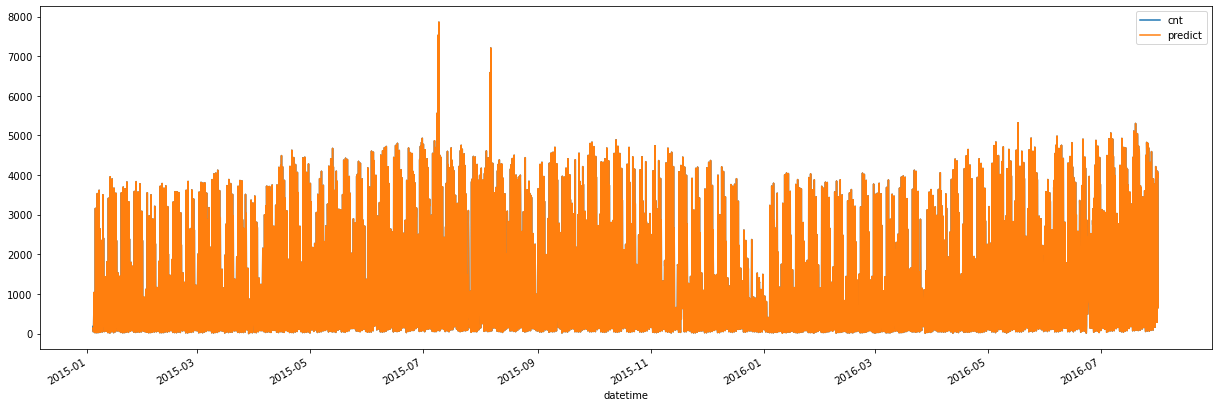

In [74]:
pd.concat([y_train, pd.DataFrame(predict_train, index=y_train.index, columns=['predict'])], axis=1).plot(kind='line', figsize=(21,7))
plt.show()

In [79]:
predict_train

array([ 138.0495233 ,  138.05240307,  134.05621897, ..., 1345.99956051,
        971.99632605,  656.99556652])

In [83]:
np.mean((y_train.values.flatten() - predict_train) ** 2)

0.14102100013828525

In [84]:
predict_test

array([371.99272276, 202.99237877, 124.99087742, ..., 336.99756498,
       223.9943215 , 138.99426791])

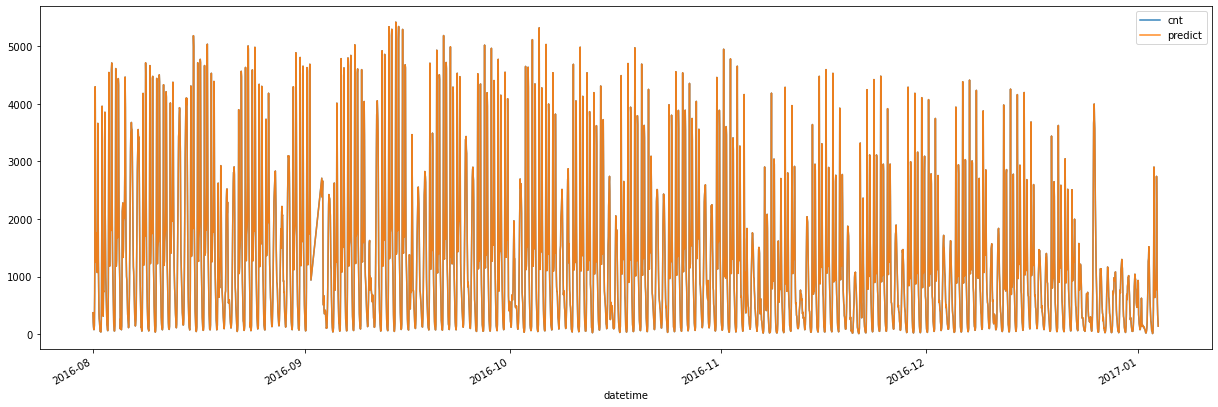

In [86]:
pd.concat([y_test, pd.DataFrame(predict_test, index=y_test.index, columns=['predict'])], axis=1).plot(kind='line', figsize=(21, 7), alpha=0.9,
                                                                                                      linewidth=1.5)
plt.show()

In [89]:
np.mean((y_test.values.flatten() - predict_test) ** 2)

0.00011012664883198042

In [90]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,diff,hour,month,lag_cnt1,lag_cnt2,dayofweek
datetime,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,-44.0,0,1,182.0,182.0,6
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,-44.0,1,1,182.0,182.0,6
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,-4.0,2,1,138.0,182.0,6
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,-62.0,3,1,134.0,138.0,6
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,-25.0,4,1,72.0,134.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,-1178.0,19,1,2220.0,2742.0,1
2017-01-03 20:00:00,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,-501.0,20,1,1042.0,2220.0,1
2017-01-03 21:00:00,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,-204.0,21,1,541.0,1042.0,1


# Toyotacorolla.csv

In [215]:
rawData = pd.read_csv('./Toyotacorolla.csv')

In [178]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [179]:
rawData.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [185]:
rawData

,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Automatic,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
Id,,,,,,,,,,,,,,,,,,,,,
1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,0,...,1,1,1,0,0,0,1,0,0,0
2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,0,...,1,0,1,0,0,0,1,0,0,0
3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,0,...,0,0,1,0,0,0,1,0,0,0
4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,0,...,0,0,1,0,0,0,1,0,0,0
5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,0,...,1,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,TOYOTA Corolla 1.3 16V HATCHB G6 2/3-Doors,7500,69,12,1998,20544,Petrol,86,1,0,...,1,1,1,0,1,1,1,0,0,0
1439,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,10845,72,9,1998,19000,Petrol,86,0,0,...,0,0,1,0,0,1,1,0,0,0
1440,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,8500,71,10,1998,17016,Petrol,86,0,0,...,0,0,1,0,0,0,1,0,0,0


In [186]:
rawData.drop(['Model', 'Fuel_Type'], axis='columns', inplace=True)

In [187]:
rawData

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
Id,,,,,,,,,,,,,,,,,,,,,
1,13500,23,10,2002,46986,90,1,0,2000,3,...,1,1,1,0,0,0,1,0,0,0
2,13750,23,10,2002,72937,90,1,0,2000,3,...,1,0,1,0,0,0,1,0,0,0
3,13950,24,9,2002,41711,90,1,0,2000,3,...,0,0,1,0,0,0,1,0,0,0
4,14950,26,7,2002,48000,90,0,0,2000,3,...,0,0,1,0,0,0,1,0,0,0
5,13750,30,3,2002,38500,90,0,0,2000,3,...,1,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,7500,69,12,1998,20544,86,1,0,1300,3,...,1,1,1,0,1,1,1,0,0,0
1439,10845,72,9,1998,19000,86,0,0,1300,3,...,0,0,1,0,0,1,1,0,0,0
1440,8500,71,10,1998,17016,86,0,0,1300,3,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
rawData.set_index('Id', inplace=True) 

In [189]:
rawTrain = rawData.loc[rawData.index < 1148, :]
rawTest = rawData.loc[rawData.index >= 1148, :]
print(rawTrain.shape, rawTest.shape)

(1142, 34) (294, 34)


In [190]:
rawData.dropna()

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
Id,,,,,,,,,,,,,,,,,,,,,
1,13500,23,10,2002,46986,90,1,0,2000,3,...,1,1,1,0,0,0,1,0,0,0
2,13750,23,10,2002,72937,90,1,0,2000,3,...,1,0,1,0,0,0,1,0,0,0
3,13950,24,9,2002,41711,90,1,0,2000,3,...,0,0,1,0,0,0,1,0,0,0
4,14950,26,7,2002,48000,90,0,0,2000,3,...,0,0,1,0,0,0,1,0,0,0
5,13750,30,3,2002,38500,90,0,0,2000,3,...,1,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,7500,69,12,1998,20544,86,1,0,1300,3,...,1,1,1,0,1,1,1,0,0,0
1439,10845,72,9,1998,19000,86,0,0,1300,3,...,0,0,1,0,0,1,1,0,0,0
1440,8500,71,10,1998,17016,86,0,0,1300,3,...,0,0,1,0,0,0,1,0,0,0


In [193]:
x_train = rawTrain.loc[:, 'Mfg_Year':]
y_train = rawTrain[['Price']]
x_test = rawTest.loc[:, 'Mfg_Year':]
y_test = rawTest[['Price']]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1142, 31) (1142, 1)
(294, 31) (294, 1)


In [194]:
model1 = sm.OLS(y_train, x_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     359.9
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:50:17   Log-Likelihood:                -9665.1
No. Observations:                1142   AIC:                         1.939e+04
Df Residuals:                    1111   BIC:                         1.955e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Mfg_Year          1417.3158     51.756     27.384      0.000    1315.765    1518.867
KM                  -0.0184      0.001    -14.613      0.000      -0.021      -0.016
HP                  27.7721      2.793      9.942      0.000      22.291      33.253
Met_Color          -30.3392     78.728     -0.385      0.700    -184.811     124.132
Automatic          339.2652    168.422      2.014      0.044       8.804     669.727
cc                  -0.0621      0.081     -0.771      0.441      -0.220       0.096
Doors               73.0864     40.221      1.817      0.069      -5.831     152.003
Cylinders        -7.097e+05   2.58e+04    -27.497      0.000    -7.6e+05   -6.59e+05
Gears               85.7222    189.608      0.452      0.651    -286.307     457.752
Quarterly_Tax        7.9346      1.314      6.037      0.000       5.356      10.513
Weight              10.4508      1.097      9.527      0.000       8.299      12.603
Mfr_Guarantee      195.7245     76.835      2.547      0.011      44.966     346.483
BOVAG_Guarantee    717.1189    136.974      5.235      0.000     448.362     985.876
Guarantee_Period    70.7339     13.510      5.236      0.000      44.226      97.242
ABS               -157.0979    151.761     -1.035      0.301    -454.869     140.673
Airbag_1           469.4630    302.688      1.551      0.121    -124.442    1063.368
Airbag_2            55.5458    147.699      0.376      0.707    -234.254     345.346
Airco              177.6129     95.025      1.869      0.062      -8.835     364.061
Automatic_airco   2389.7870    184.922     12.923      0.000    2026.951    2752.623
Boardcomputer     -297.7722    111.862     -2.662      0.008    -517.257     -78.287
CD_Player          177.4314     99.220      1.788      0.074     -17.248     372.111
Central_Lock      -141.6519    149.599     -0.947      0.344    -435.180     151.876
Powered_Windows    613.6912    149.175      4.114      0.000     320.995     906.388
Power_Steering    -577.6950    308.923     -1.870      0.062   -1183.833      28.444
Radio              640.7051    691.230      0.927      0.354    -715.557    1996.968
Mistlamps          -78.4738    112.988     -0.695      0.487    -300.168     143.220
Sport_Model        407.4110     89.874      4.533      0.000     231.068     583.754
Backseat_Divider  -167.4148    146.058     -1.146      0.252    -453.995     119.165
Metallic_Rim       190.0608     96.882      1.962      0.050      -0.032     380.154
Radio_cassette    -722.8395    692.113     -1.044      0.297   -2080.836     635.157
Tow_Bar           -205.7719     83.780     -2.456      0.014    -370.158     -41.386
==============================================================================
Omnibus:                      103.700   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.0

In [195]:
predict_train = model1.predict(x_train).values
predict_test = model1.predict(x_test).values

In [196]:
predict_train

array([15476.10320997, 14739.45825929, 15296.94999287, ...,
        7738.18846074,  5776.15235612,  7416.93523632])

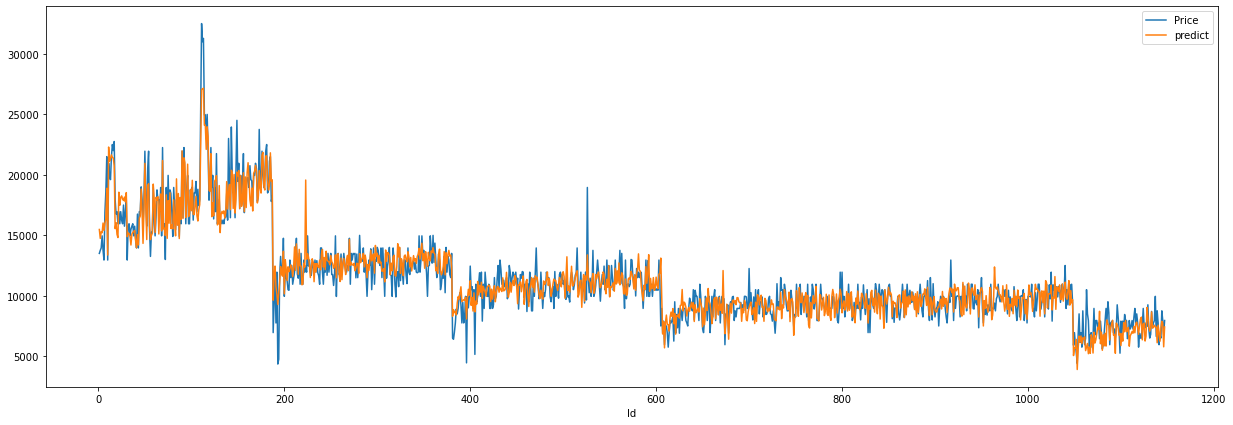

In [197]:
pd.concat([y_train, pd.DataFrame(predict_train, index=y_train.index, columns=['predict'])], axis=1).plot(kind='line', figsize=(21,7))
plt.show()

In [198]:
predict_train

array([15476.10320997, 14739.45825929, 15296.94999287, ...,
        7738.18846074,  5776.15235612,  7416.93523632])

In [199]:
np.mean((y_train.values.flatten() - predict_train) ** 2)

1314162.7282985183

In [200]:
predict_test

array([ 5205.79520559,  8553.69691969,  6162.52152494,  7232.92684703,
        7498.4661996 ,  8412.76768814,  6258.2802395 ,  6520.90944152,
        8166.20298796,  8023.34292253,  7855.73341772,  8226.6449482 ,
        7128.63703045,  8074.9098298 ,  6500.3577498 ,  6063.0312025 ,
        7136.2785076 ,  7905.45248971,  8270.64397721,  6887.49582466,
        6820.1131955 ,  6707.26647547,  8853.43022798,  7476.07580739,
        8127.2100828 ,  6171.83698356,  5344.4825114 ,  8025.70595042,
        7674.8952565 ,  7216.05520774,  7190.10203606,  6952.50442123,
        7790.15183042,  8165.65031866,  7762.32938758,  7058.22809875,
        7955.73063341,  7729.15522268,  8124.52422959,  6034.1495412 ,
        8961.94276293,  6476.25146278,  7056.35464757,  7222.34255771,
        8744.8132698 ,  7171.52803356,  7227.8463586 ,  6465.42763747,
        6282.29725603,  7372.33802136,  6105.69365282,  8266.77656184,
        7818.42069305,  7642.58440453,  6743.54916429,  7406.07079697,
      

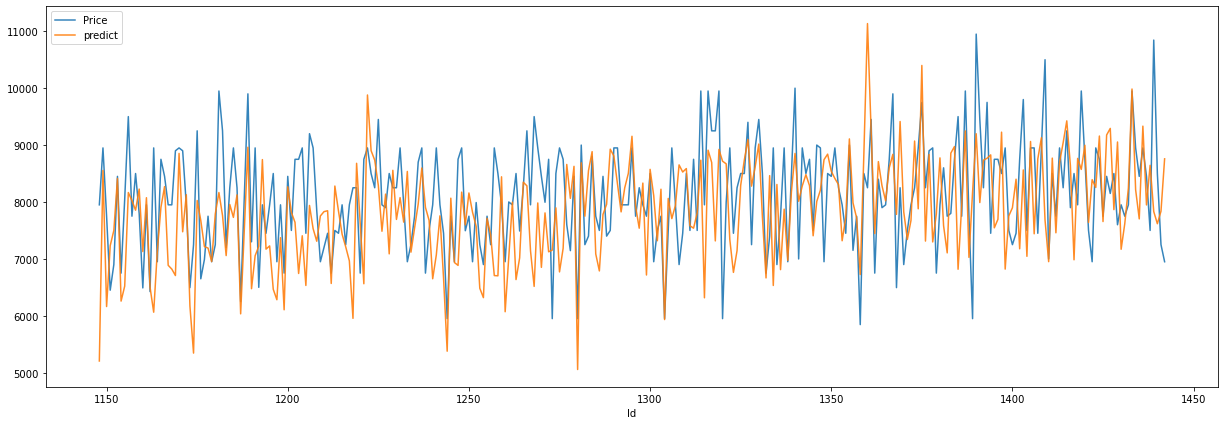

In [201]:
pd.concat([y_test, pd.DataFrame(predict_test, index=y_test.index, columns=['predict'])], axis=1).plot(kind='line', figsize=(21, 7), alpha=0.9,
                                                                                                      linewidth=1.5)
plt.show()

In [205]:
rawData.Fuel_Type.unique()

array(['Diesel', 'Petrol', 'CNG'], dtype=object)

In [206]:
rawData.Fuel_Type

0       Diesel
1       Diesel
2       Diesel
3       Diesel
4       Diesel
         ...  
1431    Petrol
1432    Petrol
1433    Petrol
1434    Petrol
1435    Petrol
Name: Fuel_Type, Length: 1436, dtype: object

In [210]:
pd.get_dummies(rawData.Fuel_Type, drop_first=True)

,Diesel,Petrol
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
1431,0,1
1432,0,1
1433,0,1
1434,0,1


In [212]:
# one-hot encoding
rawData[['Diesel', 'petrol']] = pd.get_dummies(rawData.Fuel_Type, drop_first=True)

In [216]:
rawData.drop(columns=['Model', 'Fuel_Type', 'Id'], inplace=True)

In [217]:
rawData

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,13500,23,10,2002,46986,90,1,0,2000,3,...,1,1,1,0,0,0,1,0,0,0
1,13750,23,10,2002,72937,90,1,0,2000,3,...,1,0,1,0,0,0,1,0,0,0
2,13950,24,9,2002,41711,90,1,0,2000,3,...,0,0,1,0,0,0,1,0,0,0
3,14950,26,7,2002,48000,90,0,0,2000,3,...,0,0,1,0,0,0,1,0,0,0
4,13750,30,3,2002,38500,90,0,0,2000,3,...,1,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,7500,69,12,1998,20544,86,1,0,1300,3,...,1,1,1,0,1,1,1,0,0,0
1432,10845,72,9,1998,19000,86,0,0,1300,3,...,0,0,1,0,0,1,1,0,0,0
1433,8500,71,10,1998,17016,86,0,0,1300,3,...,0,0,1,0,0,0,1,0,0,0
1434,7250,70,11,1998,16916,86,1,0,1300,3,...,0,0,0,0,0,0,1,0,0,0


In [220]:
y = rawData['Price']
x = rawData.loc[:, 'Age_08_04':]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=123)

In [221]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1005, 33) (431, 33) (1005,) (431,)


In [222]:
full_model = sm.OLS(y_train, x_train).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     311.0
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:29:55   Log-Likelihood:                -8450.2
No. Observations:                1005   AIC:                         1.696e+04
Df Residuals:                     973   BIC:                         1.712e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Age_08_04         -113.9277      4.115    -27.686      0.000    -122.003    -105.852
Mfg_Month          -98.2573     10.836     -9.068      0.000    -119.521     -76.994
Mfg_Year            -0.3102      0.905     -0.343      0.732      -2.085       1.465
KM                  -0.0187      0.001    -14.814      0.000      -0.021      -0.016
HP                  24.3894      2.951      8.266      0.000      18.599      30.180
Met_Color          -57.2331     79.666     -0.718      0.473    -213.571      99.105
Automatic          367.7577    156.944      2.343      0.019      59.769     675.746
cc                  -0.1490      0.077     -1.928      0.054      -0.301       0.003
Doors                4.1872     41.860      0.100      0.920     -77.960      86.334
Cylinders           -0.0359      0.002    -15.005      0.000      -0.041      -0.031
Gears              286.9375    197.048      1.456      0.146     -99.750     673.625
Quarterly_Tax        6.1997      1.613      3.845      0.000       3.035       9.364
Weight              13.4730      1.544      8.728      0.000      10.444      16.502
Mfr_Guarantee      320.6810     77.190      4.154      0.000     169.203     472.159
BOVAG_Guarantee    521.9704    140.376      3.718      0.000     246.495     797.446
Guarantee_Period    74.0651     16.489      4.492      0.000      41.706     106.424
ABS               -258.5172    136.866     -1.889      0.059    -527.104      10.070
Airbag_1           200.6279    265.720      0.755      0.450    -320.822     722.078
Airbag_2           -54.0228    142.123     -0.380      0.704    -332.925     224.879
Airco              165.0110     93.462      1.766      0.078     -18.398     348.420
Automatic_airco   2448.7853    207.698     11.790      0.000    2041.197    2856.374
Boardcomputer     -348.2394    122.686     -2.838      0.005    -589.000    -107.479
CD_Player          250.1767    105.335      2.375      0.018      43.466     456.887
Central_Lock      -151.7838    144.450     -1.051      0.294    -435.254     131.686
Powered_Windows    544.1766    145.354      3.744      0.000     258.934     829.419
Power_Steering    -382.5886    293.891     -1.302      0.193    -959.322     194.145
Radio              637.9746    655.483      0.973      0.331    -648.349    1924.298
Mistlamps          -18.7171    116.014     -0.161      0.872    -246.384     208.950
Sport_Model        241.5681     92.859      2.601      0.009      59.340     423.796
Backseat_Divider    55.4013    132.335      0.419      0.676    -204.294     315.096
Metallic_Rim        81.3077    100.165      0.812      0.417    -115.257     277.872
Radio_cassette    -691.0579    655.409     -1.054      0.292   -1977.236     595.120
Tow_Bar           -227.1148     83.267     -2.728      0.006    -390.517     -63.712
=======================

In [236]:
full_model_train_predict = full_model.predict(x_train)

In [237]:
pd.concat([y_train, full_model_train_predict], axis=1)

,Price,0
584,10500,10622.786681
1140,6750,5952.119611
417,10950,10873.188734
317,10950,11768.241495
1065,6550,5315.449304
...,...,...
1041,10900,10723.098874
1122,7460,8826.029280
1346,7950,7351.708683
1406,8950,8856.686600


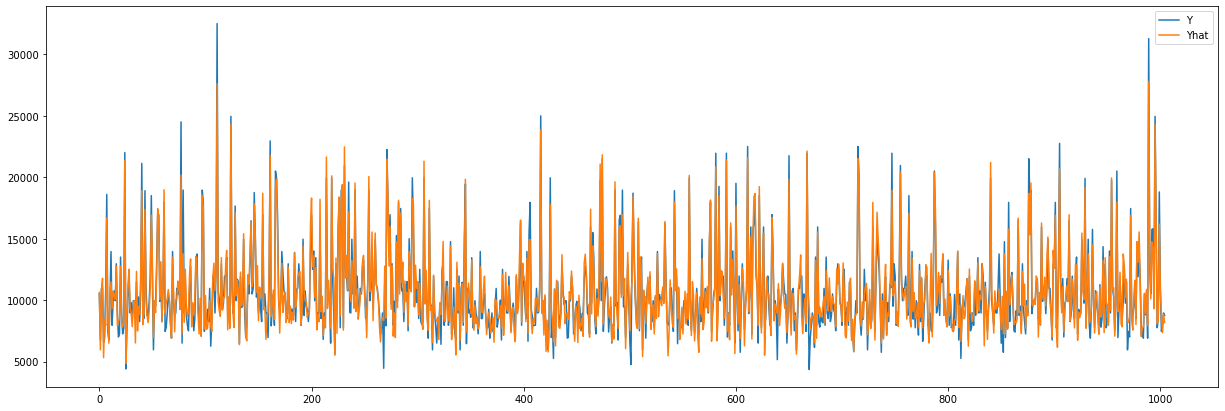

In [238]:
plt.figure(figsize=(21,7))
plt.plot(np.array(y_train), label='Y')
plt.plot(np.array(full_model_train_predict), label='Yhat')
plt.legend()
plt.show()

In [239]:
mean_absolute_error(y_true=y_train, y_pred=full_model_train_predict)

816.1886468974327

In [240]:
full_model_test_predict = full_model.predict(x_test)

In [241]:
pd.concat([y_test, full_model_test_predict], axis=1)

,Price,0
585,12950,12573.599015
61,16500,18105.904308
919,9900,10338.019307
624,7950,10349.643873
36,15950,15234.953754
...,...,...
30,12950,15222.794123
580,11930,10817.724043
1338,7499,7595.086116
1272,8450,8801.423369


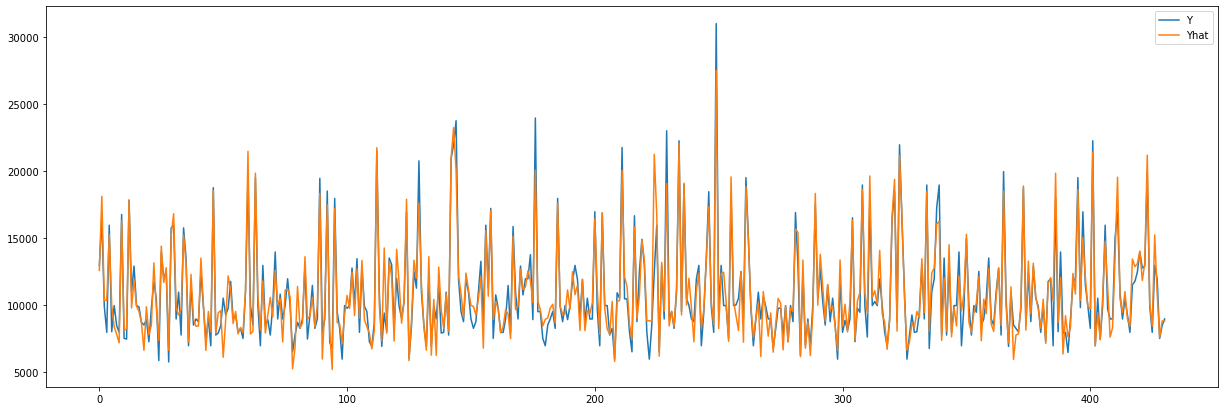

In [242]:
plt.figure(figsize=(21, 7))
plt.plot(np.array(y_test), label='Y')
plt.plot(np.array(full_model_test_predict), label='Yhat')
plt.legend()
plt.show()

In [243]:
mean_absolute_error(y_true=y_test, y_pred=full_model_test_predict)

866.0340769600343